Soham Inamdar(210100149)
<br>
Anannay Jain (210110021)

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

Read the data into a pandas dataframe
Controllable parameters are:
c26, c27, c28, c29, c30, c31, c32, c33, c39, c139, c142, c143, c155, c156, c157, c158, c160, c161, c162, c163

c51, c52, c53, c54 represent vibrations of certain critical equipment.It is important to closely monitor these vibrations and keep them under control.
Create 2 ML models-1 based on all parameters, 2-based only on controllable parameters-prediction and control


c241 represents ‘specific energy’ (energy consumed per unit output produced) which is also a critical factor.
Create ML prediction model




In [2]:

df_data=pd.read_csv("e11.csv")
lst_control=["c26", "c27", "c28", "c29", "c30", "c31", "c32", "c33", "c39", "c139", "c142", "c143", "c155", "c156", "c157", "c158", "c160", "c161", "c162", "c163"]
lst_vibrations=["c51","c52","c53","c54"]
df_data_controllable=df_data[lst_control]
df_data_vibrations=df_data[lst_vibrations]


In [3]:
df_data.describe()

In [4]:
#Obtain columns which have a non-numeric datatype
target_dtypes = [object]
columns_with_dtypes = df_data.select_dtypes(include=target_dtypes).columns
print(columns_with_dtypes)

Index(['c1'], dtype='object')


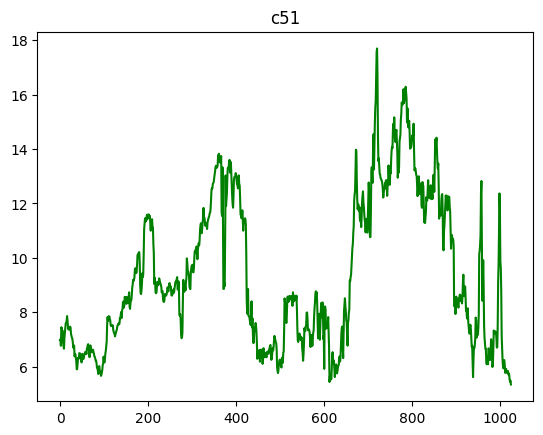

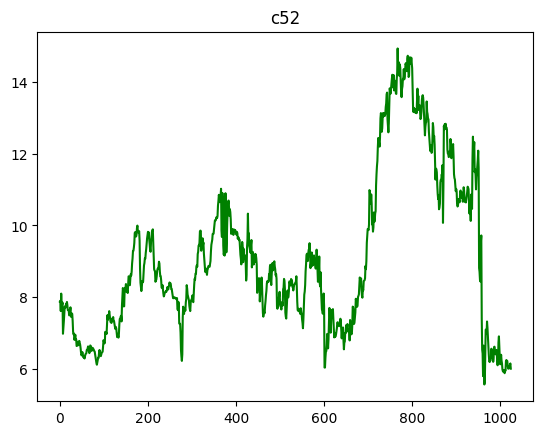

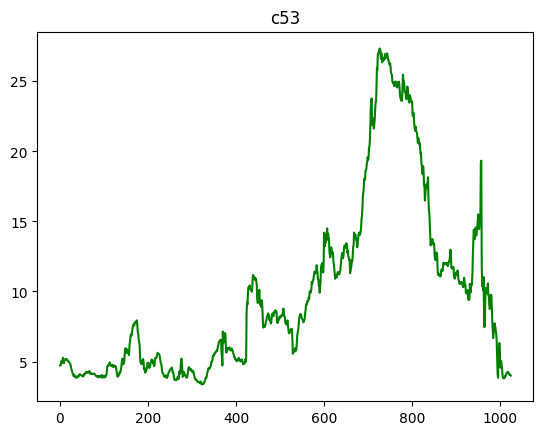

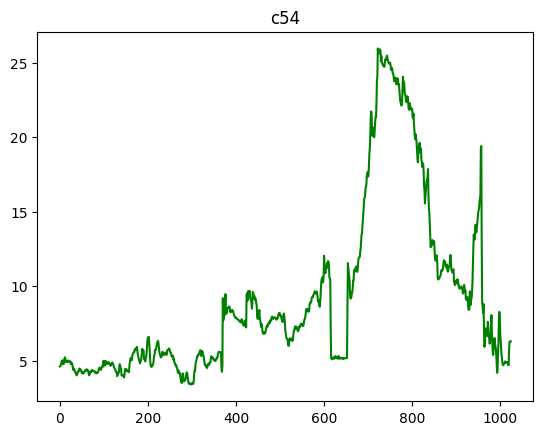

In [5]:
#Visualize critical vibrations data
for col in lst_vibrations:
    plt.plot(df_data[col],color="green")
    plt.title(col)
    plt.show()

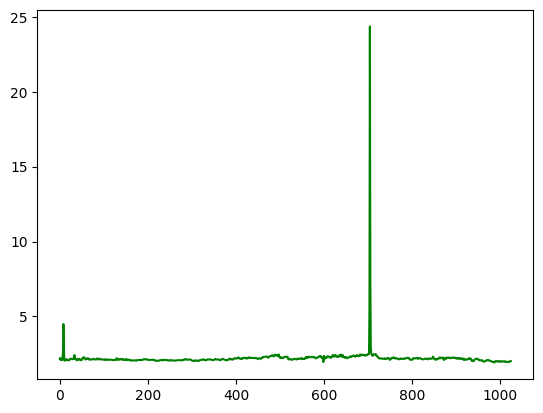

In [6]:
#Plot free energy data
plt.plot(df_data["c241"],color="green")

<Axes: >

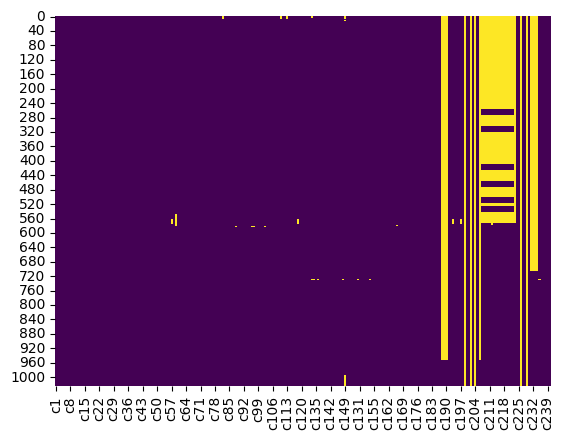

In [7]:
#Visualize null values
sns.heatmap(df_data.isnull(),cbar=False,cmap='viridis')

In [8]:
#Find all columns which have number of null values greater than 50% of the number of rows
n_values=len(df_data)
null_map=df_data.isnull().sum()
cols=df_data.columns
to_drop=[]
for i in range(len(null_map)):
    if (null_map[i]>n_values/2):
        to_drop.append(cols[i])




In [9]:
#Drop majorly null columns
df_data=df_data.drop(to_drop,axis=1)


In [10]:
#Convert date to day, month, year
df_data["c1_year"]=(pd.DatetimeIndex(df_data["c1"]).year)
df_data["c1_month"]=(pd.DatetimeIndex(df_data["c1"]).month)
df_data["c1_day"]=(pd.DatetimeIndex(df_data["c1"]).day)


In [11]:
df_data=df_data.drop(["c1"],axis=1)


In [12]:
means=df_data.mean()
stdev=df_data.std()

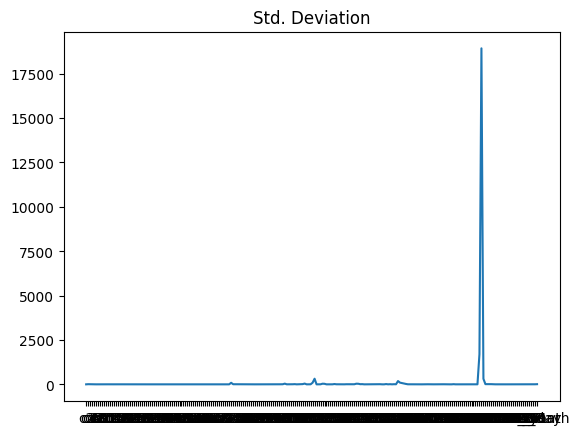

In [13]:
#Plot standard deviation
plt.plot(stdev)
plt.title("Std. Deviation")
plt.show()

In the above plot, we observe that some columns have zero standard deviation which implies that these columns have constant values and will not make a difference in the final ML model.

In [14]:

cols=df_data.columns
zero_var=[]
for i in range(len(stdev)):
    if (stdev[i]<=1e-6):
        zero_var.append(cols[i])


In [15]:
#Drop mostly constant columns
df_data=df_data.drop(zero_var,axis=1)

In [16]:
#Drop null columns
df_data=df_data.drop(["c207","c208","c209","c210","c211","c212","c213","c214","c215","c216","c217","c218","c219","c220","c221","c222"],axis=1)

In [17]:
sns.heatmap(df_data.isnull(),cbar=False,cmap='viridis')

In [18]:
#Apply linear interpolation to columns where only a small number of values are missing
df_data=df_data.interpolate(method ='linear', limit_direction ='both') 

In [19]:
sns.heatmap(df_data.isnull(),cbar=False,cmap='viridis')

In [21]:
# calculate IQR for column Height
Q1 = df_data.quantile(0.25)
Q3 = df_data.quantile(0.75)
IQR = Q3 - Q1

# identify outliers
threshold = 1.5
outliers = df_data[(df_data < Q1 - threshold * IQR) | (df_data > Q3 + threshold * IQR)]
n_outliers=[]
cols=[]
ls=[]
for i in range(outliers.shape[1]):
    n_outliers.append(outliers[pd.notnull(outliers.iloc[:,i])].shape[0])
    cols.append(outliers.columns[i])
    if(outliers[pd.notnull(outliers.iloc[:,i])].shape[0]>120):
        ls.append(outliers.columns[i])
    #print(outliers[pd.notnull(outliers.iloc[:,i])].shape[0],outliers.columns[i]) 


    
    #     print(outliers[col].unique())
# outliers[pd.notnull(outliers.iloc[:,0])]




Making the ML model

In [20]:
df_data_copy=df_data.copy(deep=False)

We have to scale(normalize) the data appropriately in order to avoid certain large values influencing our model. We will be using min-max scaling.

In [21]:
# apply normalization techniques 
for column in df_data_copy.columns: 
    df_data_copy[column] = (df_data_copy[column] - df_data_copy[column].min()) / (df_data_copy[column].max() - df_data_copy[column].min())     

# view normalized data 
#print(df_data_copy.loc[:,"c51"])

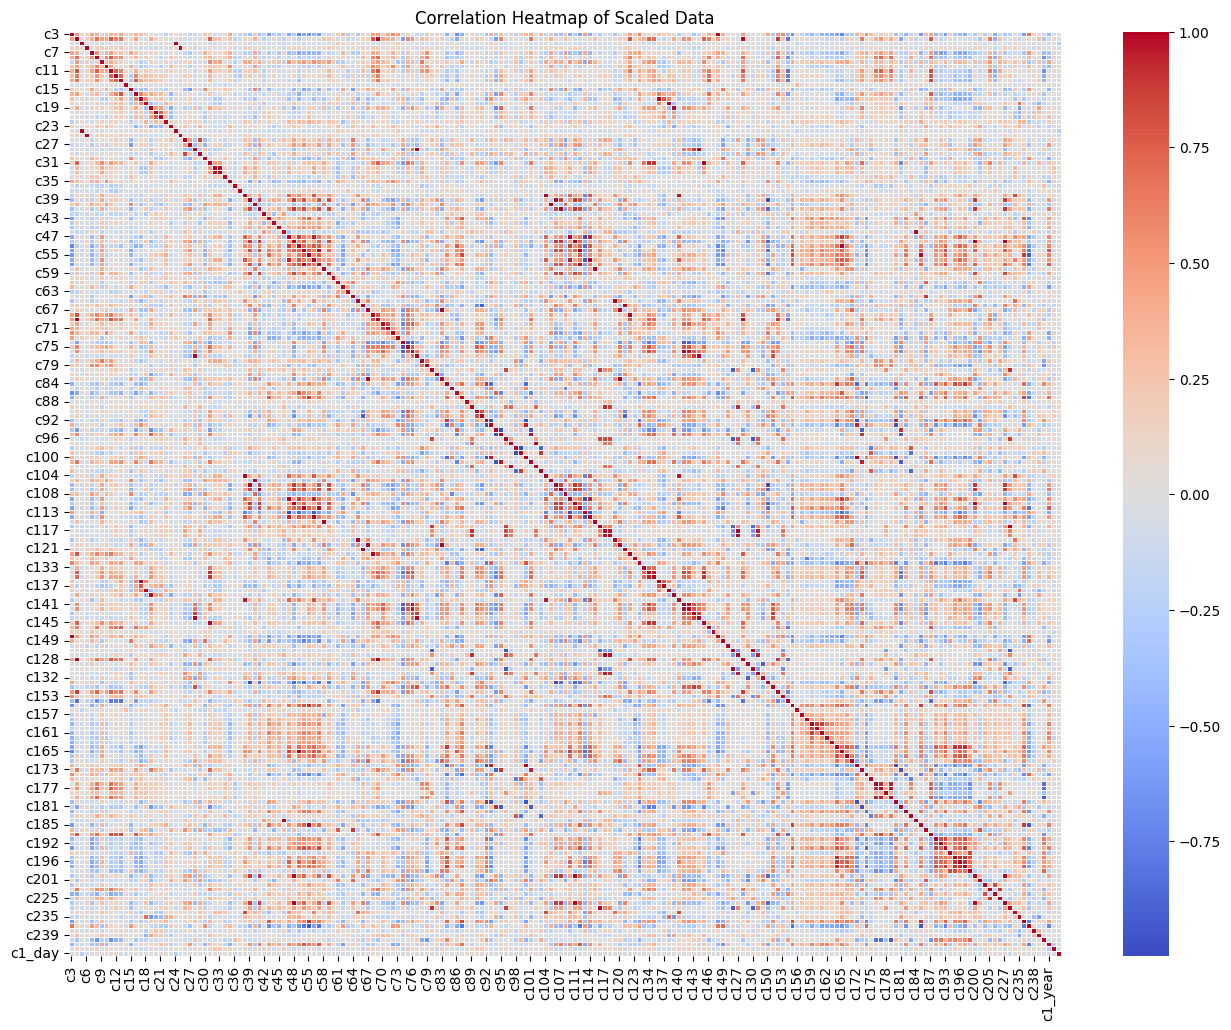

In [22]:
X = df_data_copy.drop(columns=lst_vibrations)  # Features
y = df_data_copy[lst_vibrations]  # Target variable
# Assuming you already have the scaled DataFrame (data_scaled) from the previous code

# Calculate the correlation matrix
correlation_matrix = X.corr()

# Set up the matplotlib figure
plt.figure(figsize=(16, 12))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=.5)

# Show the plot
plt.title('Correlation Heatmap of Scaled Data')
plt.show()


In [23]:
corr_df=correlation_matrix.abs()
#Define upper triangular matrix mask
mask=np.triu(np.ones_like(corr_df,dtype=bool))
tri_df=corr_df.mask(mask)
corr_thresh=0.95
to_drop=[col for col in tri_df.columns if any(tri_df[col]>corr_thresh)]
#print(len(to_drop))

In [24]:
crx = np.corrcoef(X,rowvar=False)



In [25]:
x = []
for i in range(143):
    x.append([])
    for j in range (143):
        x[i].append(crx[i,j])
#plt.plot(x[67],'yo')

In [26]:
X=X.drop(to_drop,axis=1)

In [27]:
import statsmodels.api as sm

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#THIS IS ONLY AN EXPLORATION, WE HAVE NOT USED IT IN OUR FINAL MODEL
# Assuming 'X' is your design matrix (independent variables)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]




Now, we split the dataset into train and test data.

In [29]:
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame named 'data_scaled' with 200 columns and 1000 entries
# Replace 'data_scaled' with the actual name of your DataFrame

# Define your features (X) and target variable (y) assuming you have a target column
# Replace 'target_column' with the actual name of your target column
X = df_data_copy.drop(columns=lst_vibrations)  # Features
y = df_data_copy[lst_vibrations]  # Target variable

# Split the data into training and testing sets (adjust test_size and random_state as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (820, 201)
X_test shape: (205, 201)
y_train shape: (820, 4)
y_test shape: (205, 4)


In [30]:

X_train=sm.add_constant(X_train)
X_test=sm.add_constant(X_test)


In [31]:
#Function to perform iterative feature elimination in Multiple Linear Regression(MLR)
def mlr(y,X_train,y_train,X_test,y_test):
    rsq=[]
    for i in range(0,80):
        mlr_model=sm.OLS(y_train[y],X_train).fit()
        rsq.append(mlr_model.rsquared)
        results_summary=mlr_model.summary()
        # Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
        results_as_html = results_summary.tables[1].as_html()
        summ=pd.read_html(results_as_html, header=0, index_col=0)[0]
        nx= summ.loc[summ.iloc[:,3] >0.05]
        nx=nx.iloc[:,3]
        to_drop=nx.loc[nx==nx.max()].index.tolist()
        #print(to_drop,nx.max())
        X_train=X_train.drop(to_drop,axis=1)
        X_test=X_test.drop(to_drop,axis=1)
        # columns_list = nx.index.tolist()
    print("final r_squared value :",mlr_model.rsquared)
    mlr_model=sm.OLS(y_train[y],X_train).fit()
    y_pred_test=mlr_model.predict(X_test)
    
    y_pred_test.head()
    e_test=y_test[y]-y_pred_test
    MSE = np.sum((e_test)**2)
    print("train ",MSE, y)
    y_pred_train=mlr_model.predict(X_train)
    e_train=y_train[y]-y_pred_train
    MSE = np.sum((e_train)**2)
    print("test ",MSE, y)
    
    # Plotting the R-squared values
    plt.plot(rsq, marker='o', linestyle='-', color='b')

    # Adding labels and title
    plt.xlabel('Iteration Number')
    plt.ylabel('R-squared Value')
    plt.title('R-squared Values with Iteration Number')

    # Display the plot
    plt.show()
    
    



final r_squared value : 0.9753153314872298
train  1.4238120680891644 c51
test  3.2004336259123645 c51


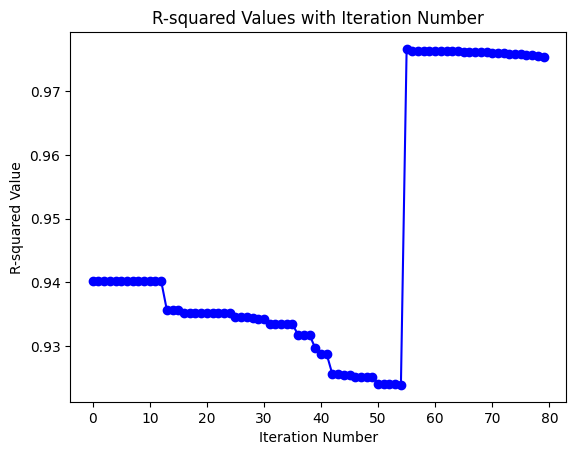

In [32]:
mlr("c51",X_train,y_train,X_test,y_test)

final r_squared value : 0.9897631249085646
train  0.8954267941301124 c52
test  1.690179888317063 c52


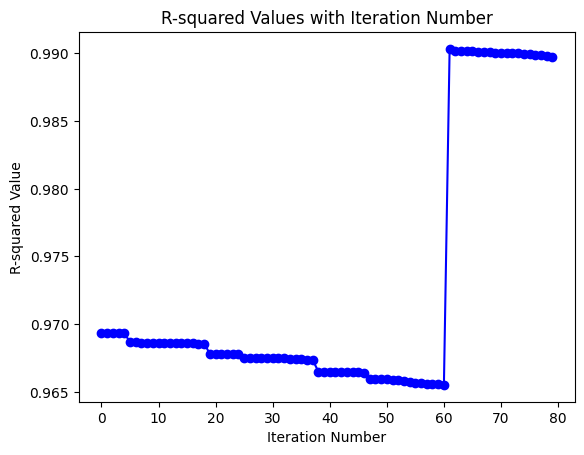

In [33]:
mlr("c52",X_train,y_train,X_test,y_test)

final r_squared value : 0.9885154030808943
train  0.8539418994257699 c53
test  1.381296013780959 c53


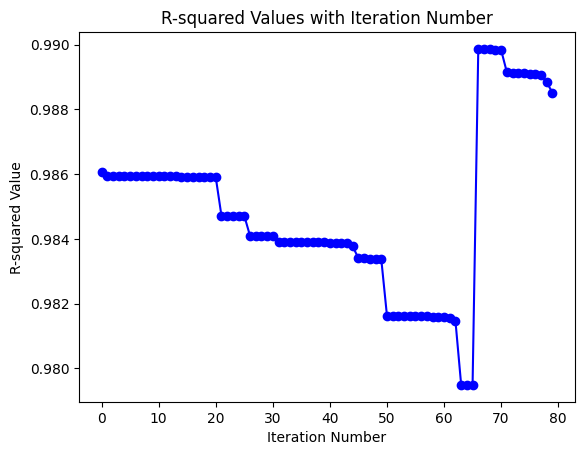

In [34]:
mlr("c53",X_train,y_train,X_test,y_test)

final r_squared value : 0.9899455831899513
train  0.580103024762608 c54
test  1.112498210509228 c54


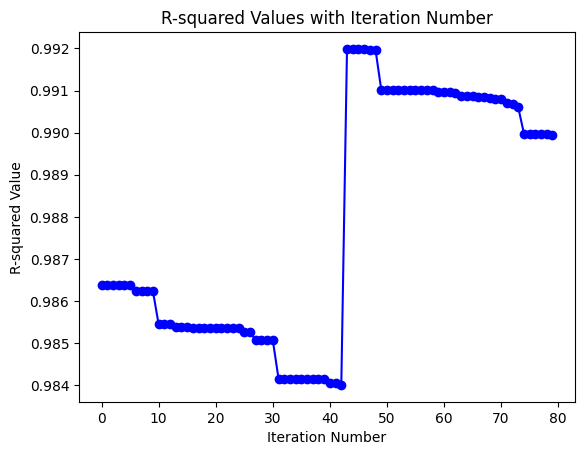

In [35]:
mlr("c54",X_train,y_train,X_test,y_test)

In [36]:
df_predvals=pd.DataFrame(columns=["c51","c52","c53","c54"])
#X and y are input and target data
X=sm.add_constant(X)
for col in df_predvals.columns:
    mlr_model = sm.OLS(y[col], X).fit()
    Y_pred = mlr_model.predict(X)
    df_predvals[col]=Y_pred




    
    

Now, we have denormalise and classify the data into SAFE, MODERATE, HIGH, CRITICAL

In [37]:
# apply denormalization techniques 
for column in df_predvals.columns:
    #print(df_data_copy[column]* (denorm_df[column].max() - denorm_df[column].min()) + (denorm_df[column].min()))
    df_predvals[column] = (df_predvals[column]* (df_data[column].max() - df_data[column].min())) + (df_data[column].min())  

# view normalized data 
#df_predvals

In [38]:
#Classify predicted values



status_bins = [0, 5, 10, 20, float('inf')]  # You can adjust the bin edges based on your criteria
labels = ['SAFE', 'MODERATE', 'HIGH','CRITICAL']

# Create a new column 'Height_Category' based on the height bins
df_predvals['c51_status'] = pd.cut(df_predvals['c51'], bins=status_bins, labels=labels, right=False)
df_predvals['c52_status'] = pd.cut(df_predvals['c52'], bins=status_bins, labels=labels, right=False)
df_predvals['c53_status'] = pd.cut(df_predvals['c53'], bins=status_bins, labels=labels, right=False)
df_predvals['c54_status'] = pd.cut(df_predvals['c54'], bins=status_bins, labels=labels, right=False)
# Display the updated DataFrame





In [39]:
print((df_predvals[df_predvals["c52_status"]=="SAFE"].count()))

c51           0
c52           0
c53           0
c54           0
c51_status    0
c52_status    0
c53_status    0
c54_status    0
dtype: int64


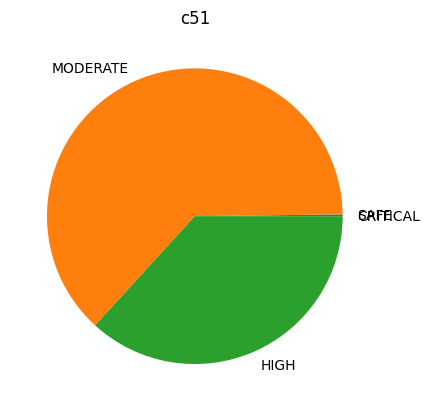

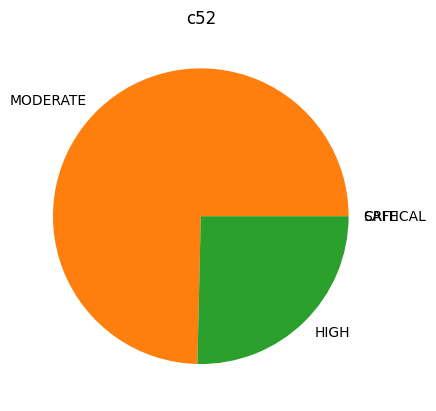

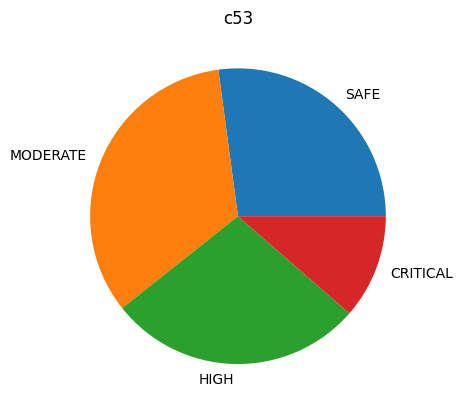

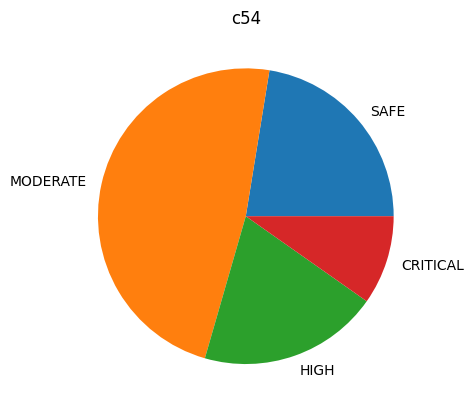

In [40]:
#Visualize number of each categories
c51=[2,646,377,0]
c52=[0,765,260,0]
c53=[278,344,286,117]
c54=[230,493,202,100]
plt.pie(c51,labels=labels)
plt.title("c51")
plt.show()
plt.pie(c52,labels=labels)
plt.title("c52")
plt.show()
plt.pie(c53,labels=labels)
plt.title("c53")
plt.show()
plt.pie(c54,labels=labels)
plt.title("c54")
plt.show()

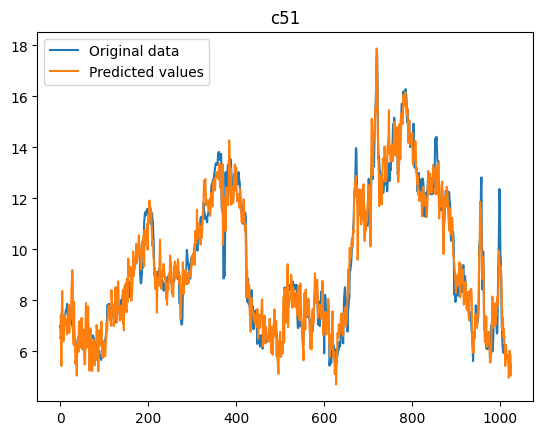

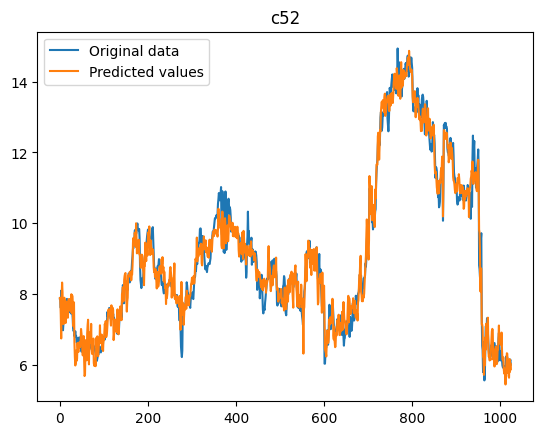

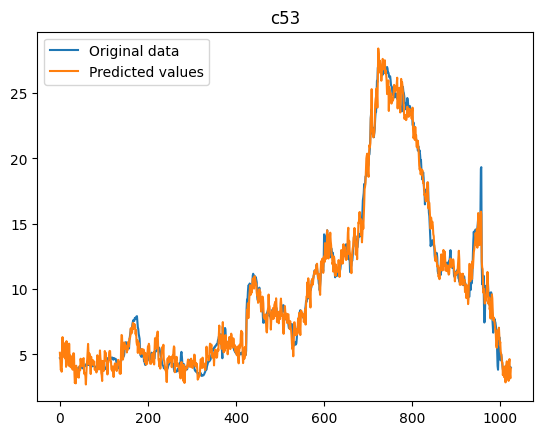

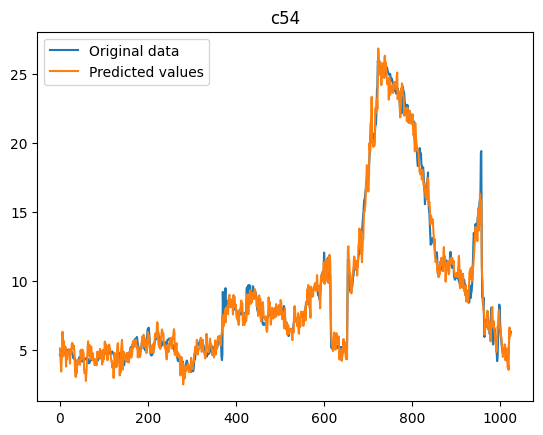

In [41]:
plt.plot(df_data["c51"],label="Original data")
plt.plot(df_predvals["c51"], label="Predicted values")
plt.title("c51")
plt.legend()
plt.show()
plt.plot(df_data["c52"],label="Original data")
plt.plot(df_predvals["c52"], label="Predicted values")
plt.title("c52")
plt.legend()
plt.show()
plt.plot(df_data["c53"],label="Original data")
plt.plot(df_predvals["c53"], label="Predicted values")
plt.title("c53")
plt.legend()
plt.show()
plt.plot(df_data["c54"],label="Original data")
plt.plot(df_predvals["c54"], label="Predicted values")
plt.title("c54")
plt.legend()
plt.show()

Apply Model using only controllable parameters


In [42]:
newcols=[]
X1=X.copy(deep=False)
y1=y.copy(deep=False)

for col in X1.columns:
    if (col in lst_control):
        newcols.append(col)
X1=X1[newcols]

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# Assuming 'X' contains controllable parameters and 'y' contains vibration data
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Train a RandomForestRegressor (you can choose a different model)
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
pred1=model.predict(X_train)
mse1=mean_squared_error(y_train,pred1)
mse = mean_squared_error(y_test, predictions)
print(f'Train Mean Squared Error: {mse1}')
print(f'Test Mean Squared Error: {mse}')

# Feature importance
feature_importance = model.feature_importances_
important_features = sorted(zip(X1.columns, feature_importance), key=lambda x: x[1], reverse=True)
print('Most important features:', important_features)


Train Mean Squared Error: 0.0003059555260531852
Test Mean Squared Error: 0.0018668302338323449
Most important features: [('c155', 0.6470485817218945), ('c161', 0.08878428437549582), ('c143', 0.06390390250213215), ('c158', 0.03424996999222465), ('c39', 0.033976788266753905), ('c26', 0.01683675478017011), ('c29', 0.016799363379007178), ('c28', 0.014482301544484853), ('c31', 0.014211116619161732), ('c157', 0.014188039480131592), ('c142', 0.008745366390386575), ('c32', 0.008368402342695555), ('c30', 0.007979448575853195), ('c27', 0.0069962777972354204), ('c139', 0.006879833681336573), ('c33', 0.006724592797856832), ('c163', 0.00515056852090962), ('c160', 0.0026646470667465423), ('c162', 0.0019710169713460556), ('c156', 3.874319417728542e-05)]


In [45]:
pred1=model.predict(X1)
df_pred_1=pd.DataFrame(pred1,columns=["c51","c52","c53","c54"])

In [46]:
for column in df_pred_1:
    #print(df_data_copy[column]* (denorm_df[column].max() - denorm_df[column].min()) + (denorm_df[column].min()))
    df_pred_1[column] = (df_pred_1[column]* (df_data[column].max() - df_data[column].min())) + (df_data[column].min())  

# view normalized data 
#df_predvals

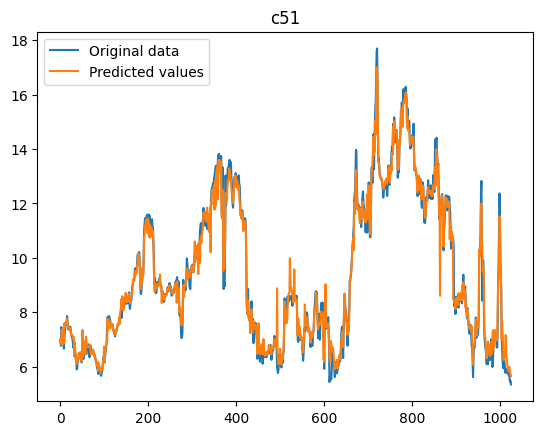

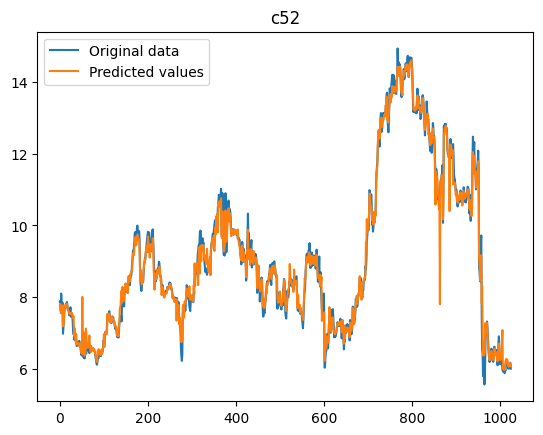

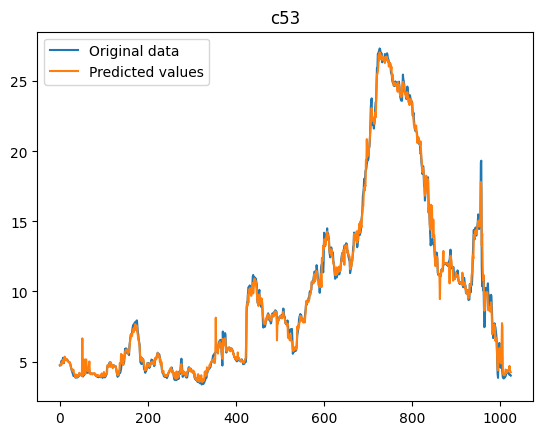

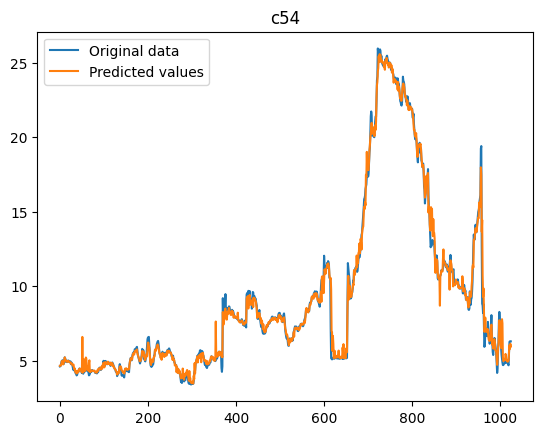

In [47]:
plt.plot(df_data["c51"],label="Original data")
plt.plot(df_pred_1["c51"], label="Predicted values")
plt.title("c51")
plt.legend()
plt.show()
plt.plot(df_data["c52"],label="Original data")
plt.plot(df_pred_1["c52"], label="Predicted values")
plt.title("c52")
plt.legend()
plt.show()
plt.plot(df_data["c53"],label="Original data")
plt.plot(df_pred_1["c53"], label="Predicted values")
plt.title("c53")
plt.legend()
plt.show()
plt.plot(df_data["c54"],label="Original data")
plt.plot(df_pred_1["c54"], label="Predicted values")
plt.title("c54")
plt.legend()
plt.show()

Create model for specific enrgy

In [48]:
newcols=[]
X2=X.copy(deep=False)
y2=df_data_copy["c241"]



In [49]:
X2=X2.drop(["c241"],axis=1)

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
#X1=X1.drop(["c156"],axis=1)
# Assuming 'X' contains controllable parameters and 'y' contains vibration data
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Train a RandomForestRegressor (you can choose a different model)
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
pred1=model.predict(X_train)
mse1=mean_squared_error(y_train,pred1)
mse = mean_squared_error(y_test, predictions)
print(f'Train Mean Squared Error: {mse1}')
print(f'Test Mean Squared Error: {mse}')

# Feature importance
feature_importance = model.feature_importances_
important_features = sorted(zip(X2.columns, feature_importance), key=lambda x: x[1], reverse=True)
print('Most important features:', important_features[:7])
imp_arr=[]
imp_idx=[]
for i in range(len(important_features)):
    imp_arr.append(important_features[i][1])
    imp_idx.append(important_features[i][0])


Train Mean Squared Error: 0.00016544047387158516
Test Mean Squared Error: 2.9839456759217693e-06
Most important features: [('c193', 0.09711137999003742), ('c92', 0.09245043029398191), ('c151', 0.08445014057093354), ('c103', 0.08126482641097094), ('c192', 0.07811658942770054), ('c180', 0.06537944152679644), ('c187', 0.05459289481128651)]


Select features with importance more than 0.05

In [51]:
min_features=[]
for i in range(len(imp_arr)):
    if (imp_arr[i]>0.01):
        min_features.append(imp_idx[i])

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# Assuming 'X' contains controllable parameters and 'y' contains vibration data
X2=X2[min_features[:5]]
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
# Train a RandomForestRegressor (you can choose a different model)
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
pred1=model.predict(X_train)
mse1=mean_squared_error(y_train,pred1)
mse = mean_squared_error(y_test, predictions)
print(f'Train Mean Squared Error: {mse1}')
print(f'Test Mean Squared Error: {mse}')

# Feature importance
feature_importance = model.feature_importances_
important_features = sorted(zip(X2.columns, feature_importance), key=lambda x: x[1], reverse=True)
print('Most important features:', important_features)
arr=[]
idx=[]
for i in range(len(important_features)):
    arr.append(important_features[i][1])
    idx.append(important_features[i][0])


Train Mean Squared Error: 0.00011942486204111839
Test Mean Squared Error: 6.840907094243078e-06
Most important features: [('c193', 0.31887452618823664), ('c192', 0.22523208090486296), ('c92', 0.16904746870204268), ('c103', 0.15765755662488032), ('c151', 0.12918836757997743)]


In [53]:
#Denormalize values
pred=model.predict(X2)
pred = (pred* (df_data["c241"].max() - df_data["c241"].min())) + (df_data["c241"].min())  



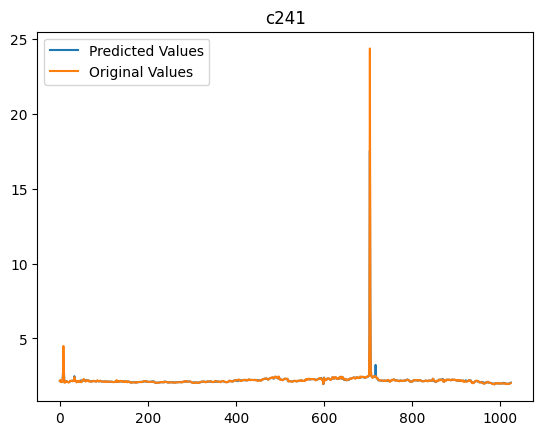

In [54]:
plt.plot(pred,label="Predicted Values")
plt.plot(df_data["c241"],label="Original Values")
plt.legend()
plt.title("c241")
plt.show()